In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [3]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [4]:
data[data['goal'] < 5]['success_rate'].mean()

3315.4035573094015

<AxesSubplot:>

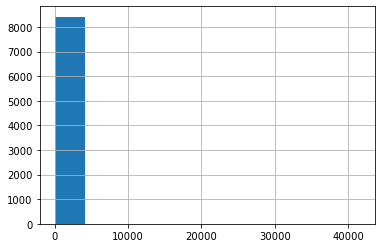

In [5]:
data['success_rate'].hist(bins=10)

In [6]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [7]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [8]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'created', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [9]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [10]:
def draw_hist(df, features, bar_type=None, n_bins=10):
    bar_type = 'bar' if bar_type == None else bar_type
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            axes[i, j].hist(df[features[4 * i + j]], histtype=bar_type, bins=n_bins)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Количество проектов с таким {features[4 * i + j]}', size=14)

In [11]:
def draw_scatter(df, col):
    plt.figure(figsize=(14, 10))
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'])
    

In [21]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    std = df[col_name].std()
    mean = df[col_name].mean()
    result = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
    print(f'{col_name}: {len_was - result.shape[0]} lines deleted')
    return result    

created: 179 lines deleted
n_pled_t: 91 lines deleted
goal: 67 lines deleted
period: 43 lines deleted
26
success_rate: 84 lines deleted


(7931, 39)

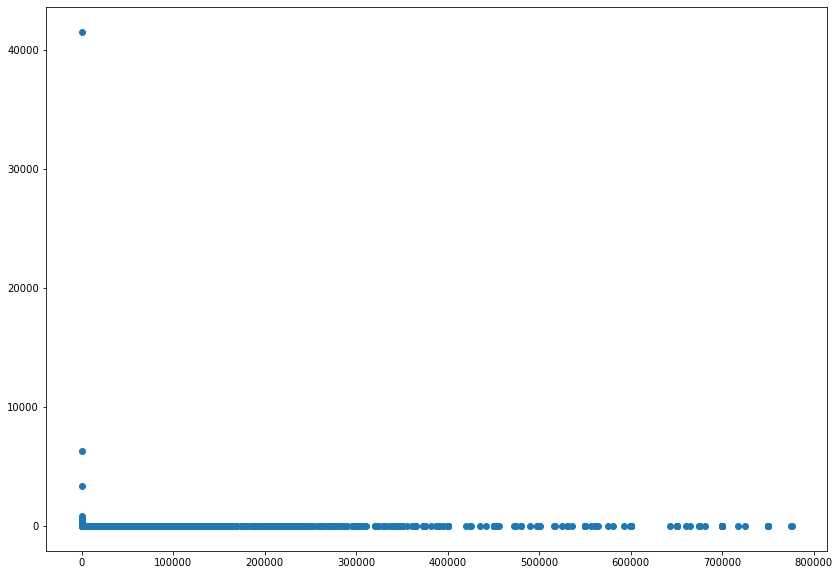

In [24]:
# Remove emissions
df = data.copy()
df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
df = del_n_sigmas_emissions(df, 'created')
df = del_n_sigmas_emissions(df, 'n_pled_t')
df = del_n_sigmas_emissions(df, 'goal') # Probably remove < 5.0 projects too
df = del_n_sigmas_emissions(df, 'period')
draw_scatter(df, 'goal')
len_was = df.shape[0]
df = df[df['goal'] > 15]
print(len_was - df.shape[0])
df = del_n_sigmas_emissions(df, 'success_rate')

df.shape

In [368]:
data[data['success_rate'] > 200]['goal'].value_counts()

5000.00     29
10000.00    19
1000.00     18
500.00      17
20000.00    14
            ..
4567.36      1
3793.05      1
22784.23     1
447.11       1
760.65       1
Name: goal, Length: 272, dtype: int64

((8015, 39),
 count      8015.000000
 mean      39374.935289
 std       85087.909924
 min          18.640000
 25%        3596.140000
 50%       10000.000000
 75%       35000.000000
 max      775803.910000
 Name: goal, dtype: float64)

<Figure size 432x288 with 0 Axes>

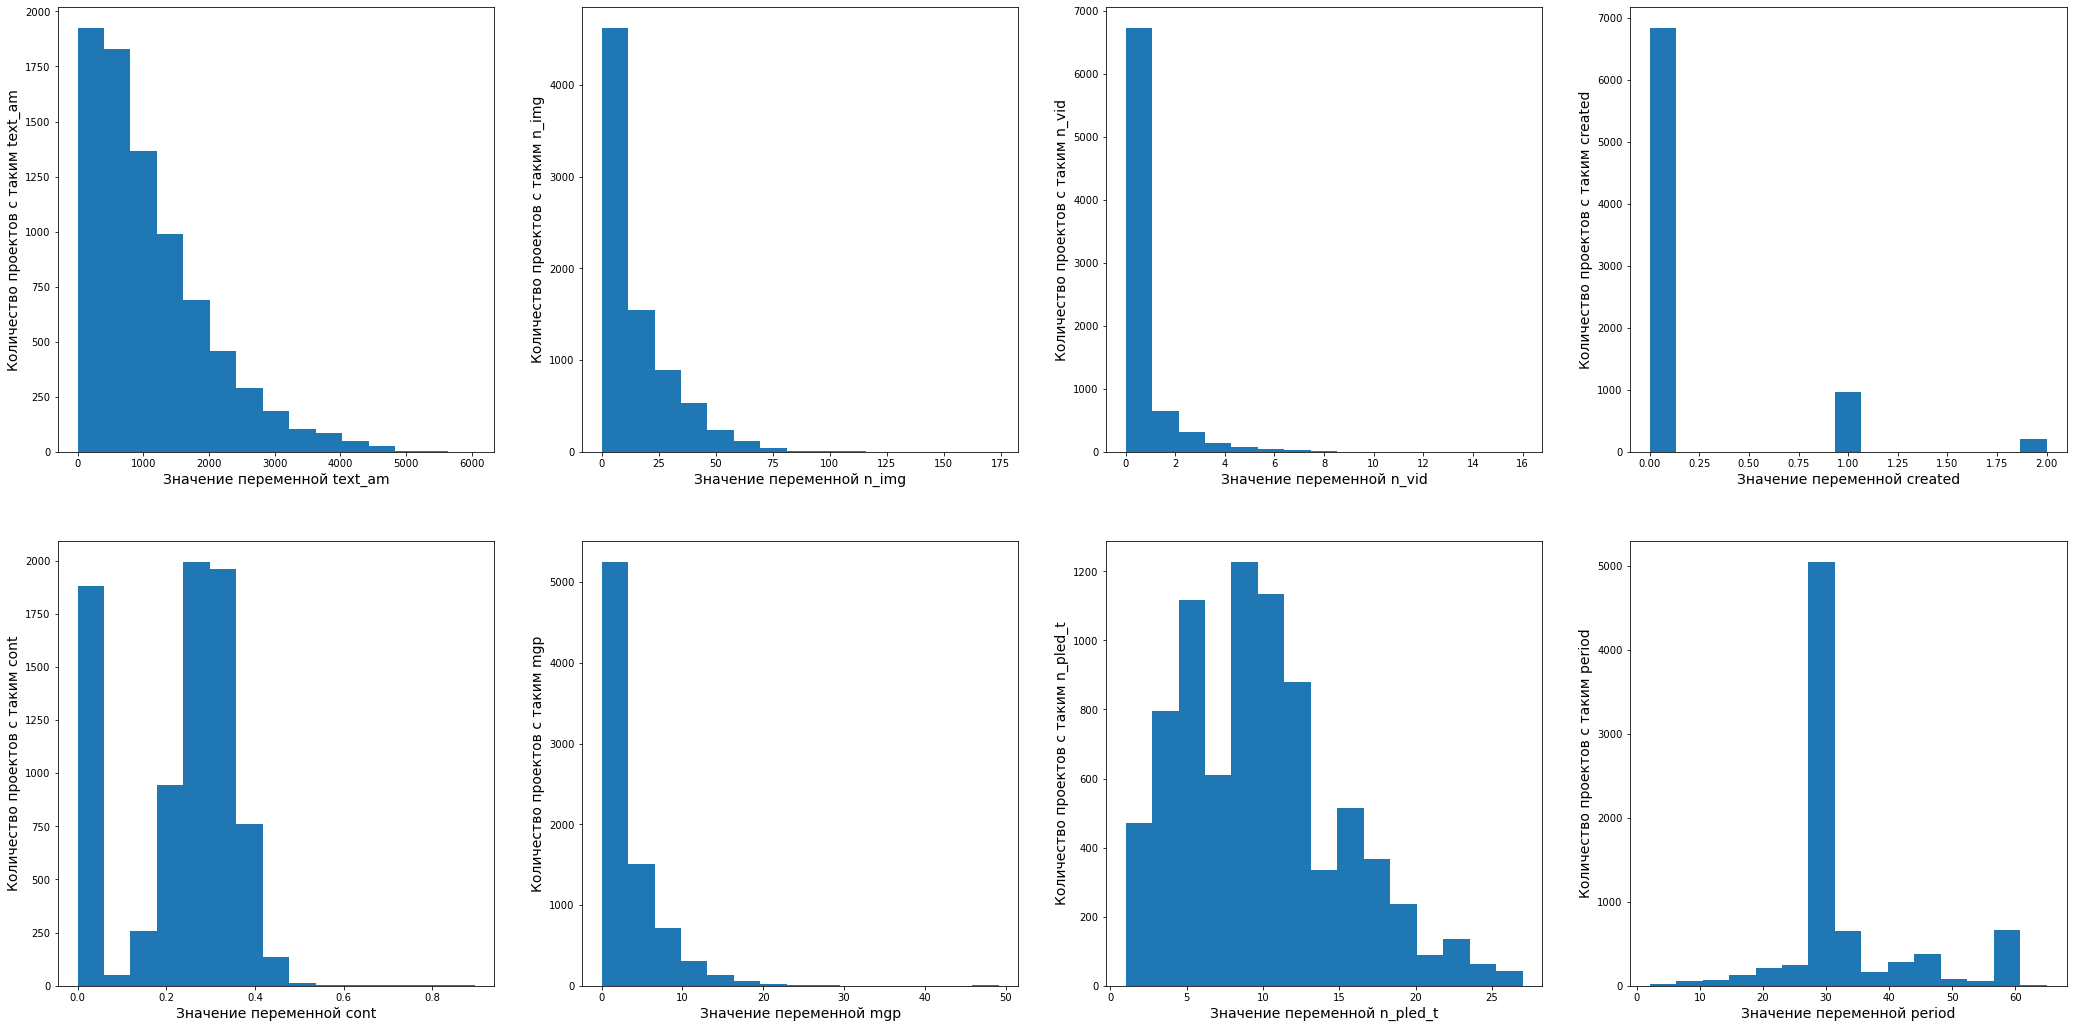

In [369]:
draw_hist(df, futures + ['period'], n_bins=15)
df.shape, df['goal'].describe()

In [370]:
# Descriptive statistics
desc = df[futures].describe()
desc.loc[:'count'] = desc.loc[:'count'].astype(np.int64)
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,created,cont,mgp,n_pled_t
count,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000,8015.000000
mean,1116.671740,14.054648,0.727261,0.173799,0.223782,3.124560,9.775421
std,902.283721,16.302413,1.294524,0.444148,0.137903,3.900903,5.279530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,417.000000,1.000000,0.000000,0.000000,0.145248,0.213500,6.000000
50%,873.000000,8.000000,0.000000,0.000000,0.267978,1.734000,9.000000
75%,1570.000000,22.000000,1.000000,0.000000,0.321772,4.573876,13.000000
max,6042.000000,174.000000,16.000000,2.000000,0.894847,49.141376,27.000000


In [371]:
pd.DataFrame(df.corr()['success_rate'][futures])

,success_rate
text_am,0.114198
n_img,0.116505
n_vid,0.178679
created,0.082697
cont,0.129180
mgp,0.144584
n_pled_t,0.099836


In [372]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            elif col == 'cont':
                n_conts = []
                step = 0.05
                for v in np.arange(0, df['cont'].max(), step):
                    s = df[(df['cont'] >= v) & (df['cont'] < v + step)]['cont']
                    if s.shape[0] > 2: 
                        n_conts.append((f'{(2 * v + step) / 2}', v, s.sum() / s.shape[0]))

                n_conts = sorted(n_conts, key=lambda x: x[1])

                xs = [k for title, k, v in n_conts]
                ys = [v for title, k, v in n_conts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

In [373]:
def split_array_by_parts(array_len, n_splits):
    """
    Returns indices for split parts
    """
    step = 0
    if array_len % n_splits == 0:
        step = array_len // n_splits
    else:
        step = array_len // n_splits + 1
    i = 0
    result = []
    while i < array_len:
        result.append((i, min(i + step, array_len)))
        i += step
    return result


def draw_dep(df, cols, n_intervals):
    step = 1.0 / n_intervals
    
    n_rows = 2
    n_cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(36, 18), sharey=False)
    
    indices = split_array_by_parts(df.shape[0], n_intervals)
    
    for i in range(n_rows):
        for j in range(n_cols):
            if n_cols * i + j == len(cols):
                return
            
            col = cols[n_cols * i + j]
            plot_vals = {}
            repeats = {}
            xs = []
            ys = []
            
            sorted_df = df.sort_values(by=[col])
            for start, stop in indices:
                cur_vals = sorted_df.iloc[start : stop]
                col_median = cur_vals[col].median()
                s_r_mean = cur_vals['success_rate'].mean()
                
                xs.append(col_median)
                ys.append(s_r_mean)
            if col == 'text_am':
                print(xs)
            new_xs, new_ys = [], []
            reps = {}
            vals = {}
            for x, y in zip(xs, ys):
                if x not in reps:
                    reps[x] = 0
                    vals[x] = []
                reps[x] += 1
                vals[x].append(y)
            for x, n_reps in reps.items():
                new_ys.append(sum(vals[x]) / n_reps)
                es = 0
                if col == 'text_am':
                    x /= 100
                new_xs.append(float(f'{x:.2f}'))
                
                
            axes[i, j].bar(new_xs, new_ys)
            if col == 'text_am':
                axes[i, j].set_xlabel(f'Среднее значение {col}, в сотнях.')
            else:
                axes[i, j].set_xlabel(f'Среднее значение {col}')
            axes[i, j].set_ylabel(f'Среднее значение success_rate')            

[76.0, 128.0, 167.0, 198.0, 234.0, 268.0, 300.0, 330.0, 367.0, 401.0, 437.0, 481.0, 523.0, 567.0, 612.0, 655.0, 702.0, 750.0, 797.0, 849.0, 903.0, 966.0, 1021.0, 1082.0, 1149.0, 1211.0, 1285.0, 1356.0, 1445.0, 1538.0, 1622.0, 1719.0, 1839.0, 1967.0, 2100.0, 2297.0, 2505.0, 2794.0, 3244.0, 4042.0]


<Figure size 432x288 with 0 Axes>

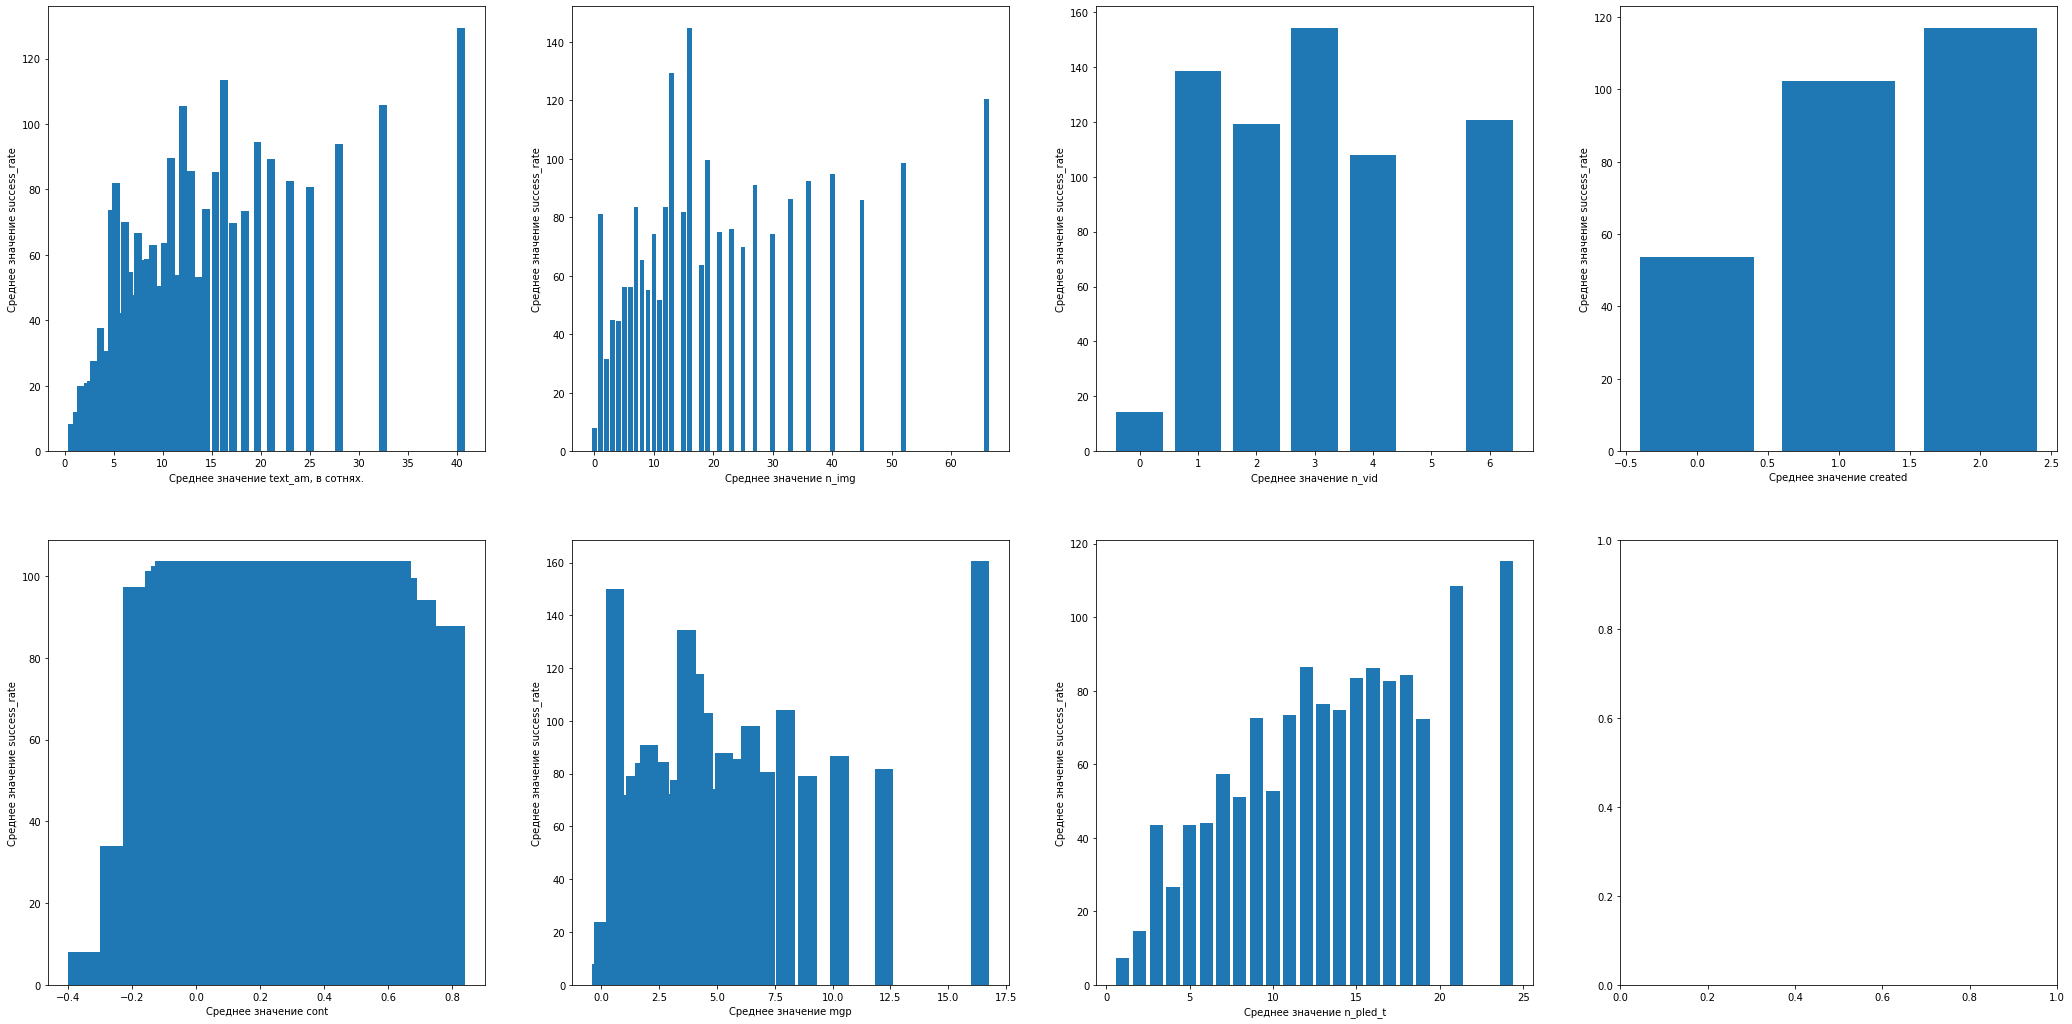

In [374]:
# draw_dependencies(df, futures)
draw_dep(df, futures, 40)

In [375]:
for col, val in zip(futures, [800, 20, 1, None, None, 0.6, 3]):
    print(col, val)
    if val == None:
        continue
    # plt.figure(figsize=(10,8))
    x = df[df[col] <= val][col]
    y = df[df[col] > val][col]

    # x.hist()
    # y.hist()

    u1, p = mannwhitneyu(x, y, alternative='less', use_continuity=False)
    print(col, 1.0 - p, u1)

text_am 800
text_am 1.0 0.0
n_img 20
n_img 1.0 0.0
n_vid 1
n_vid 1.0 0.0
created None
cont None
mgp 0.6
mgp 1.0 0.0
n_pled_t 3
n_pled_t 1.0 0.0


In [376]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [377]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
columns = numeric_columns + binary_columns

In [378]:
def test_mse(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    
    return mse

In [379]:
train_X, test_X, train_y, test_y = train_test_split(df[columns], df[target_column], train_size=0.8, random_state=42)

In [380]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_X)
test_x_data = scaler.transform(test_X)
test_y_data = test_y

In [381]:
# Simple Linear Regression
model = LinearRegression()
model.fit(train_data, train_y)

test_mse(model, train_data, train_y), test_mse(model, test_x_data, test_y_data), model.coef_

(46744.9525761305,
 16139.674363624876,
 array([-14.54303419,  14.5591558 , -31.75897246,  26.89061189,
          6.20419707,   2.17981123, -16.65794587,  -2.79032795,
          6.6850636 ,   7.20104691,   4.37314453,   8.85332173,
         40.54889377,  11.52202476,  11.26781271,   0.52845717,
         -2.83917507,  -3.75989531,  -6.1492785 ,  -3.50064228,
         -6.96898005,   2.81769306,  -2.05338811,  -0.64523257,
          3.99320837,  -7.68558265,   0.19139172,   0.97043147,
          5.75062936]))

In [382]:
# Testing regression /w L1 regularization
lasso = Lasso()
lasso.fit(train_data, train_y)

test_mse(lasso, train_data, train_y), test_mse(lasso, test_x_data, test_y_data), lasso.coef_

(46799.96776391228,
 15984.241081742417,
 array([-14.11586609,  11.38906856, -21.09747934,  26.40897478,
          2.45058345,   0.        , -11.01224714,  -0.        ,
          0.        ,   7.01186654,   3.78328093,   8.17461063,
         32.71724198,  10.91573788,  10.27402745,   0.        ,
         -2.07504685,  -2.75557326,  -5.52200476,  -2.56020692,
         -5.88054759,   1.68067804,  -0.95904677,  -0.        ,
          3.0462243 ,  -6.38119036,   0.        ,   0.15425417,
          5.05907218]))

In [383]:
# Testing regression /w L2 regularization
ridge = Ridge()
ridge.fit(train_data, train_y)

test_mse(ridge, train_data, train_y), test_mse(ridge, test_x_data, test_y_data), ridge.coef_

(46744.95321648575,
 16138.922659784466,
 array([-14.54070256,  14.54898766, -31.70845465,  26.88729268,
          6.19904045,   2.18051649, -16.63996157,  -2.79633334,
          6.67681344,   7.20080165,   4.37258114,   8.85272073,
         40.50485253,  11.52074981,  11.26611943,   0.52751572,
         -2.83930515,  -3.75917371,  -6.14890977,  -3.5002563 ,
         -6.9672995 ,   2.81703115,  -2.05274672,  -0.64447357,
          3.99195824,  -7.68454085,   0.19224623,   0.96973818,
          5.75019225]))

In [384]:
elastic = ElasticNet()
elastic.fit(train_data, train_y)

test_mse(elastic, train_data, train_y), test_mse(elastic, test_x_data, test_y_data), elastic.coef_

(47205.61671318133,
 15868.080051830864,
 array([-9.37438396,  6.52836179, -0.        , 18.06503757,  3.07220336,
         0.54511603, -5.19201469, -3.12915765, -0.61020046,  6.09983089,
         3.92567083,  6.78947239, 12.19217876,  8.49206821,  7.08616803,
         0.05125918, -1.93137968, -1.79753132, -4.01828707, -1.91055004,
        -3.82955438,  1.47561443, -0.55153526, -0.10686752,  2.97651642,
        -4.22380282,  1.03190321,  1.00771726,  4.5759811 ]))

In [350]:
ols = sm.OLS(df['success_rate'], df[columns])
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
summary_df

,coef,std err,t,P>|t|,[0.025,0.975]
goal,-0.000002,3.000000e-07,-5.161,0.000,-0.000002,-9.600000e-07
text_am,0.000100,3.760000e-05,3.143,0.002,0.000044,0.000000e+00
n_img,-0.016100,3.000000e-03,-5.123,0.000,-0.022000,-1.000000e-02
n_vid,0.213800,1.900000e-02,10.985,0.000,0.176000,2.520000e-01
n_pled_t,0.011300,6.000000e-03,1.910,0.056,-0.000000,2.300000e-02
min_pled_t,0.000076,0.000000e+00,0.438,0.662,-0.000000,0.000000e+00
max_pled_t,-0.000048,1.800000e-05,-2.643,0.008,-0.000083,-1.230000e-05
mean_pled_t,-0.000013,0.000000e+00,-0.102,0.919,-0.000000,0.000000e+00
step_pled_t,0.000100,0.000000e+00,1.022,0.307,-0.000000,0.000000e+00
cr_time,0.000100,6.490000e-05,2.017,0.044,0.000004,0.000000e+00


In [348]:
# Get mean coeffs for futures
coeffs = np.zeros((len(columns)))
rounds = 20
for i in range(20):
    inp = df[columns]
    train_y = df[target_column]
    scaler = StandardScaler()

    train_data = scaler.fit_transform(inp)
    
    model = LinearRegression()
    model.fit(train_data, train_y)
    coeffs += model.coef_
    
    lasso = Lasso()
    lasso.fit(train_data, train_y)
    coeffs += lasso.coef_
    
    ridge = Ridge()
    ridge.fit(train_data, train_y)
    coeffs += ridge.coef_
    
    elastic = ElasticNet()
    elastic.fit(train_data, train_y)
    coeffs += elastic.coef_
    
mean_coeffs = coeffs / (rounds * 4)
coeffs = [(k, v) for k, v in zip(columns, mean_coeffs)]
coeffs.sort(key=lambda x: abs(x[1]), reverse=True)
for k, v in coeffs:
    print(f'{k}: {v:.3f}')

mgp: 0.171
n_vid: 0.138
n_img: -0.133
max_pled_t: -0.083
goal: -0.065
cont: 0.064
text_am: 0.054
rpg: 0.048
created: 0.048
action: -0.037
n_pled_t: 0.035
strategy: -0.031
is_site: 0.027
step_pled_t: 0.026
cr_time: 0.026
indie: 0.025
survival: -0.023
horror: -0.021
fighting: -0.017
backed: 0.016
shooter: -0.014
arcade: 0.013
simulator: -0.010
mmo: -0.010
adventure: 0.008
min_pled_t: 0.007
platformer: 0.003
mean_pled_t: -0.003
quest: -0.001


In [267]:
# Neural network
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [53]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 175, 8):
        if rate < i + 25:
            return type_
        type_ += 1
    return 8

In [54]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
print(df[['success_rate', 'succes_type']].head(20))
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

    success_rate  succes_type
0       0.100012            0
1    1714.220076            8
2       3.460000            0
3       0.010000            0
4       8.082090            0
5     254.160000            8
6     104.620000            4
7      11.800000            0
8       8.257500            0
9       0.020000            0
10      1.101250            0
11      0.000000            0
12     22.448000            0
13      3.400000            0
14      0.157083            0
15    100.200000            4
16    132.800022            5
17      1.236000            0
18      0.950000            0
19    229.933333            8


In [55]:
df.columns

Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
       'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
       'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
       'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
       'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
       'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
       'succes_type'],
      dtype='object')

In [56]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']

numeric_data = numeric_columns + binary_columns
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

dataset = df[numeric_data]
target = df[target_col]

['goal', 'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'mgp', 'cont', 'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest', 'adventure', 'is_site'] succes_type


In [57]:
model = nn.Sequential(
    nn.BatchNorm1d(28),
    nn.Linear(28, 24),
    nn.ReLU(),
    
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    
    nn.BatchNorm1d(20),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [58]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(self.df.iloc[i])[:-1], torch.Tensor(self.df.iloc[i])[-1].to(torch.long)

In [59]:
from torch.utils.data import DataLoader


train, test = train_test_split(dataset, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [65]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(20)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5084)
accuracy:  tensor(0.7386)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5082)
accuracy:  tensor(0.7455)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5060)
accuracy:  tensor(0.7474)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5052)
accuracy:  tensor(0.7438)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5016)
accuracy:  tensor(0.7485)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5061)
accuracy:  tensor(0.7511)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4982)
accuracy:  tensor(0.7534)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4990)
accuracy:  tensor(0.7506)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4967)
accuracy:  tensor(0.7520)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4988)
accuracy:  tensor(0.7525)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4961)
accuracy:  tensor(0.7531)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5006)
accuracy:  tensor(0.7563)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4945)
accuracy:  tensor(0.7540)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4894)
accuracy:  tensor(0.7586)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4933)
accuracy:  tensor(0.7555)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4908)
accuracy:  tensor(0.7594)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4984)
accuracy:  tensor(0.7517)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4938)
accuracy:  tensor(0.7537)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4912)
accuracy:  tensor(0.7555)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4932)
accuracy:  tensor(0.7508)


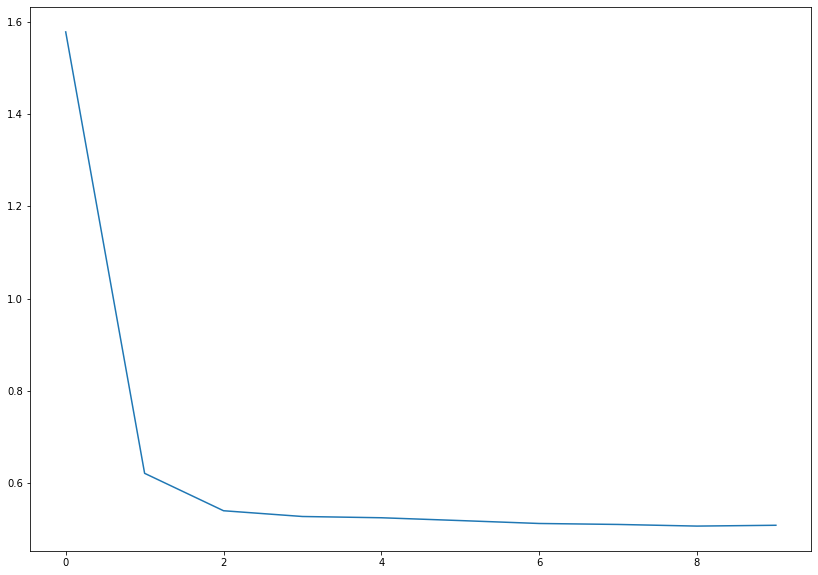

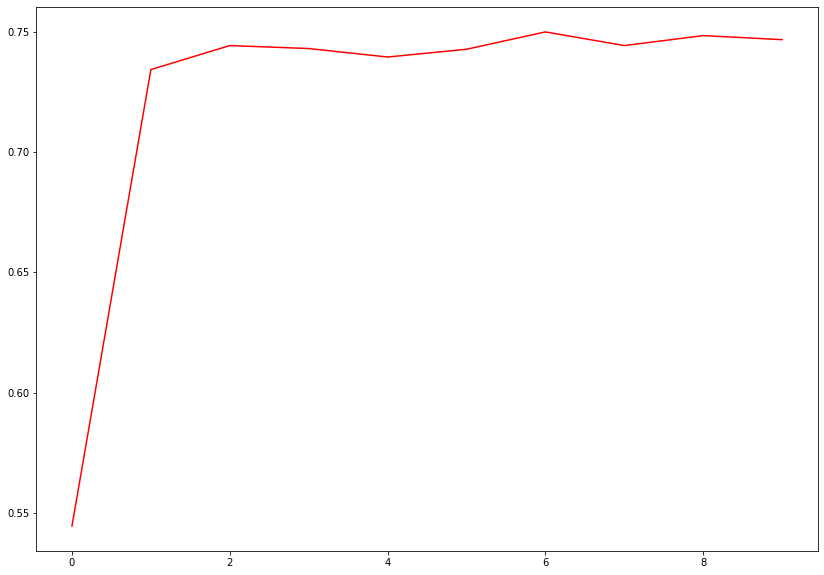

In [61]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [113]:
model.eval()

preds = []
real = []

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        for val in outp.argmax(-1):
            preds.append(val.item())
        for val in yb:
            real.append(val.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)

torch.Tensor(accuracies).mean(), torch.Tensor(accuracies).median()

(tensor(0.7443), tensor(0.7500))

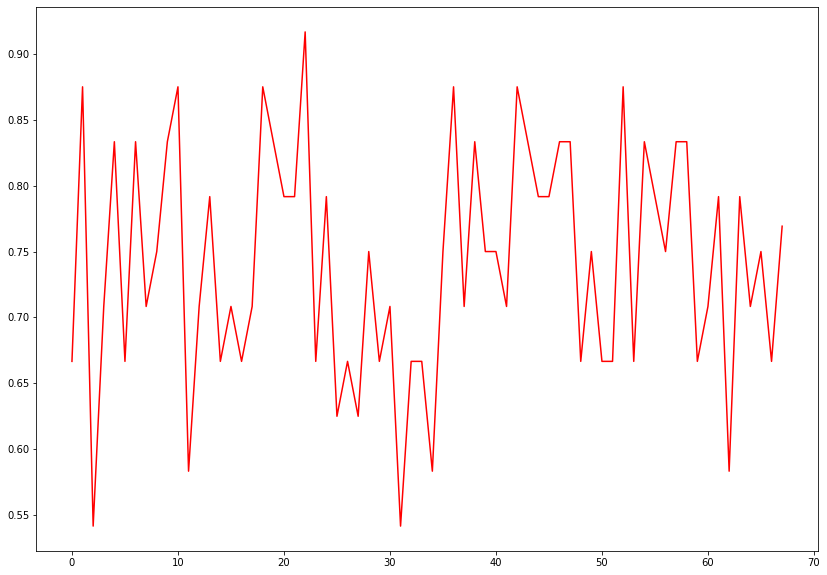

In [63]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')

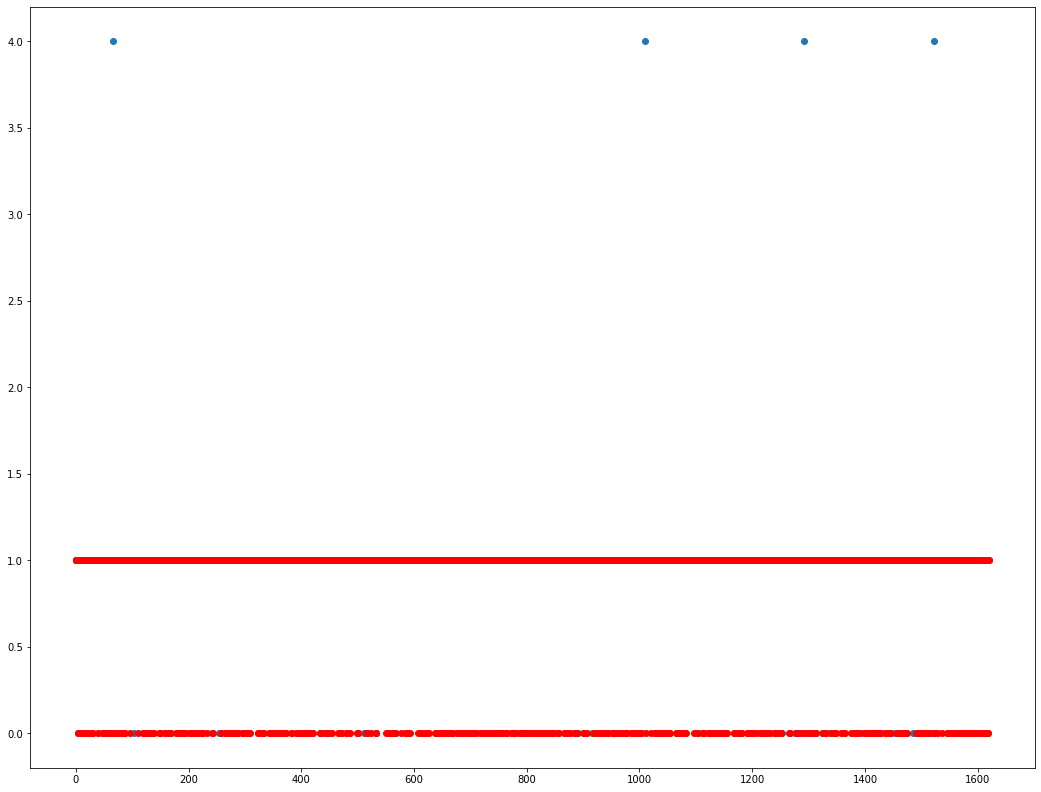

In [64]:
plt.figure(figsize=(18, 14))
plt.scatter(np.arange(len(preds)), preds)
plt.scatter(np.arange(len(real)), real, c='red')